In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from dpks import QuantMatrix

In [2]:
ms_data = pd.read_csv(
    "../0_data/proteins_train_filtered.tsv"
    , sep="\t"
)

In [3]:
design_matrix_otrain = pd.read_csv(
    "../0_data/design_matrix_train.tsv",
    sep='\t'
)

In [4]:
# urinary_tract_infection
# blood_stream_infection
# abdominal_infection
# skin_and_soft_tissue_infection
# pneumonia

In [5]:
def preprocess_design_matrix(design_matrix):

    design_matrix = design_matrix[design_matrix['verified_infection'] == 1]

    design_matrix = design_matrix[
        (design_matrix['urinary_tract_infection'] == 1) |
        # (design_matrix['blood_stream_infection'] == 1) |
        (design_matrix['abdominal_infection'] == 1) |
        (design_matrix['skin_and_soft_tissue_infection'] == 1) |
        (design_matrix['pneumonia'] == 1)
    ]

    design_matrix['group'] = np.where(
        design_matrix['urinary_tract_infection'] == 1, 2, 1
    )

    design_matrix['sample'] = design_matrix['injection']

    return design_matrix

In [6]:
def preprocess_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]

    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix     


# Model Training

In [7]:
design_matrix_train = preprocess_design_matrix(design_matrix_otrain.copy())

<Axes: xlabel='urinary_tract_infection', ylabel='Count'>

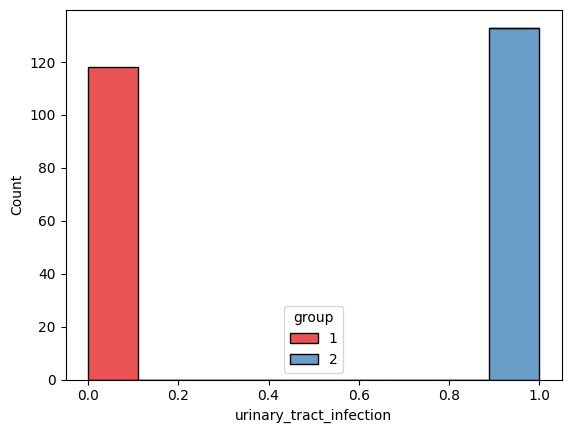

In [8]:
sns.histplot(
    design_matrix_train,
    x="urinary_tract_infection",
    hue="group",
    palette="Set1",
    multiple="stack"
)

In [9]:
design_matrix_train['group'].value_counts()

group
2    133
1    119
Name: count, dtype: int64

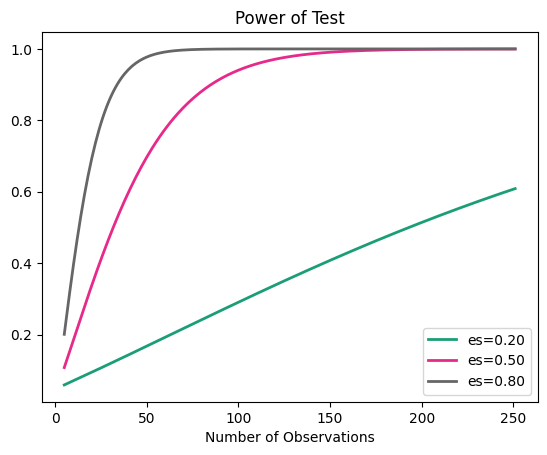

In [10]:
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt

# parameters for power analysis
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, design_matrix_train.shape[0]))


analysis = TTestIndPower()

analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

In [11]:
quant_matrix_train = preprocess_data(ms_data, design_matrix=design_matrix_train)

In [12]:
quant_matrix_train = quant_matrix_train.compare(
    method="linregress",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [13]:
quant_matrix_train.write("de_results/uti_de_proteins.tsv")

In [14]:
quant_matrix_de = quant_matrix_train.to_df()

<Axes: xlabel='Log2FoldChange2-1', ylabel='-Log10CorrectedPValue2-1'>

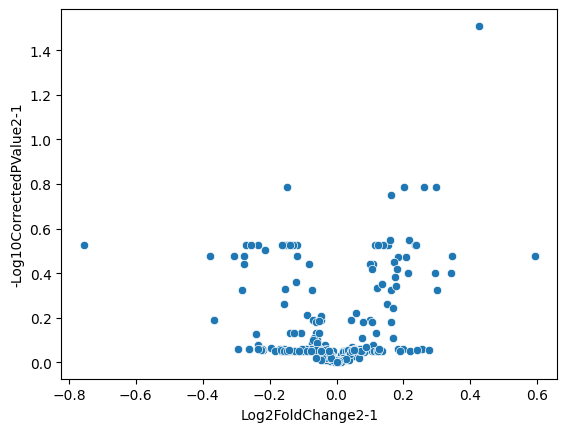

In [15]:
sns.scatterplot(
    data=quant_matrix_de,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1"
)

In [16]:
qm_filtered = (
    
    QuantMatrix(
        quantification_file=quant_matrix_de,
        design_matrix_file=design_matrix_train
    )
    
)

In [17]:
training_data, y = qm_filtered.to_ml(feature_column="ProteinLabel")

In [18]:
protein_columns = training_data.columns.to_list()

In [19]:
len(protein_columns)

287

In [20]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

X = training_data.copy()

protein_scaler = StandardScaler()

X[protein_columns] = protein_scaler.fit_transform(X[protein_columns])

X = X.copy()

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    random_state=42,
    #penalty="l1",
    class_weight="balanced",
    #C=0.1,
    #solver="liblinear",
    max_iter=1000
)

# protein_clf = BaggingClassifier(
#     estimator=protein_clf
# )

In [22]:
y['label'].value_counts()

label
1    133
0    119
Name: count, dtype: int64

In [23]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight


class_weight = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y.values.ravel()),
    y=y.values.ravel()
)

class_weight = dict(zip(np.unique(y.values.ravel()), class_weight))

class_weight

{0: 1.0588235294117647, 1: 0.9473684210526315}

In [24]:
# sample_weight = compute_sample_weight(
#     class_weight=class_weight,
#     y=y.values.ravel()
# )

In [25]:
from mrmr import mrmr_classif
selected_proteins = mrmr_classif(X=X[protein_columns], y=y.values.ravel(), K=50)

100%|██████████| 50/50 [00:16<00:00,  3.09it/s]


In [26]:
selected_proteins

['C163A_HUMAN',
 'ITIH2_HUMAN',
 'PZP_HUMAN',
 'A2AP_HUMAN',
 'MBL2_HUMAN',
 'EIF3M_HUMAN',
 'PIGR_HUMAN',
 'LDHA_HUMAN',
 'COL10_HUMAN',
 'APOH_HUMAN',
 'FCG3A_HUMAN',
 'LKHA4_HUMAN',
 'FCN3_HUMAN',
 'ZA2G_HUMAN',
 'PGRP2_HUMAN',
 'PTPRG_HUMAN',
 'APOC1_HUMAN',
 'PLSL_HUMAN',
 'ENPL_HUMAN',
 'MASP2_HUMAN',
 'IBP7_HUMAN',
 'F13A_HUMAN',
 'BGH3_HUMAN',
 'IC1_HUMAN',
 'CATB_HUMAN',
 'TTHY_HUMAN',
 'VSIG4_HUMAN',
 'CO4B_HUMAN',
 'FGL1_HUMAN',
 'HGFA_HUMAN',
 'CSF1R_HUMAN',
 'CALR_HUMAN',
 'HRG_HUMAN',
 'FBLN5_HUMAN',
 'SODE_HUMAN',
 'ITIH1_HUMAN',
 'FHR2_HUMAN',
 'APOA4_HUMAN',
 'CETP_HUMAN',
 'MASP1_HUMAN',
 'SHBG_HUMAN',
 'VWF_HUMAN',
 'ADA2_HUMAN',
 'CRIS3_HUMAN',
 'LDHB_HUMAN',
 'SPP24_HUMAN',
 'CAMP_HUMAN',
 'CO2_HUMAN',
 'PHLD_HUMAN',
 'COIA1_HUMAN']

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, HistGradientBoostingClassifier


protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [28]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3)
eval_result = cross_validate(
    protein_clf, X[selected_proteins], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.7375420875420876,
 0.7718614718614719,
 0.7420634920634921,
 0.7431300181300181)

In [29]:
from dpks.interpretation import BootstrapInterpreter

protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_proteins,
    downsample_background=True,
    shuffle_iterations=100
)

In [30]:
protein_interpreter.fit(X[selected_proteins].values, y.values.ravel(), protein_clf)

In [31]:
protein_importances = protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [32]:
protein_importances.head(20)

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
33,FBLN5_HUMAN,0.930538,2.0,0.779393,2.0,0.835407,3.0,1.000000,1.0,1.000000,...,0.750103,2.0,1.000000,1.0,0.860624,0.931186,0.175626,2.94,2.0,2.963822
0,C163A_HUMAN,1.000000,1.0,0.600269,4.0,0.476305,11.0,0.730211,2.0,0.774231,...,1.000000,1.0,0.710463,5.0,0.674842,0.681841,0.264236,8.11,4.0,9.742021
9,APOH_HUMAN,0.594365,13.0,1.000000,1.0,0.856260,2.0,0.381839,10.0,0.666198,...,0.376199,10.0,0.428448,17.0,0.655874,0.664014,0.235028,7.50,5.0,7.501515
10,FCG3A_HUMAN,0.593913,14.0,0.547429,6.0,1.000000,1.0,0.104885,41.0,0.671439,...,0.297760,14.0,0.600217,8.0,0.536585,0.519856,0.300535,14.21,9.5,14.048469
15,PTPRG_HUMAN,0.606529,9.0,0.307805,19.0,0.501879,9.0,0.330419,14.0,0.562051,...,0.362881,11.0,0.282232,27.0,0.488401,0.451825,0.193409,12.77,10.5,8.241132
45,SPP24_HUMAN,0.296244,28.0,0.331010,14.0,0.777673,5.0,0.304734,16.0,0.831768,...,0.246394,20.0,0.513813,12.0,0.469927,0.450233,0.243051,15.43,13.0,12.233631
27,CO4B_HUMAN,0.355238,24.0,0.657533,3.0,0.098034,34.0,0.466741,7.0,0.517563,...,0.574552,5.0,0.292045,25.0,0.445858,0.458025,0.226630,16.20,12.0,13.018247
2,PZP_HUMAN,0.440574,19.0,0.315046,18.0,0.562764,8.0,0.453352,8.0,0.459107,...,0.401152,8.0,0.432965,15.0,0.435488,0.426706,0.212705,16.20,14.0,11.359151
19,MASP2_HUMAN,0.363157,22.0,0.349662,13.0,0.439320,13.0,0.294923,18.0,0.075245,...,0.037943,43.0,0.070403,47.0,0.423475,0.403476,0.240569,18.00,15.5,13.210036
21,F13A_HUMAN,0.272308,31.0,0.561982,5.0,0.403281,14.0,0.651848,3.0,0.156090,...,0.217524,21.0,0.383578,18.0,0.414018,0.401345,0.189391,16.77,14.5,10.472528


In [33]:
selected_proteins = protein_importances.head(10)['feature'].to_list()

In [34]:
from dpks.interpretation import Classifier


protein_clf = Classifier(protein_clf)

In [35]:
selected_features = selected_proteins[:10]

In [36]:
for feature in selected_features:

    print(feature)

FBLN5_HUMAN
C163A_HUMAN
APOH_HUMAN
FCG3A_HUMAN
PTPRG_HUMAN
SPP24_HUMAN
CO4B_HUMAN
PZP_HUMAN
MASP2_HUMAN
F13A_HUMAN


In [37]:
protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [38]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[selected_features], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, 
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.6991582491582492,
 0.7535699714402284,
 0.7182539682539683,
 0.7197714322714323)

In [39]:
cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[protein_columns], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, 
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.669023569023569, 0.6324074074074074, 0.6190476190476191, 0.6163493913493914)

In [40]:
from dpks.interpretation import BootstrapInterpreter

final_protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_features,
    downsample_background=True,
    shuffle_iterations=100
)

In [41]:
final_protein_interpreter.fit(X[selected_features].values, y.values.ravel(), protein_clf)

In [42]:
final_protein_importances = final_protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [43]:
final_protein_importances

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
1,C163A_HUMAN,1.000000,1.0,1.000000,1.0,0.791741,4.0,1.000000,1.0,1.000000,...,1.000000,1.0,1.000000,1.0,0.909509,1.000000,0.158592,1.99,1.0,1.749430
0,FBLN5_HUMAN,0.502314,3.0,0.949023,2.0,0.880203,2.0,0.838482,2.0,0.629730,...,0.532388,2.0,0.658799,2.0,0.723767,0.710471,0.189972,3.11,3.0,1.693094
2,APOH_HUMAN,0.549254,2.0,0.874340,3.0,0.697015,5.0,0.781659,3.0,0.549136,...,0.458277,3.0,0.513931,4.0,0.689149,0.675273,0.216713,3.61,3.0,1.948296
8,MASP2_HUMAN,0.416286,5.0,0.486700,7.0,0.539177,8.0,0.347653,6.0,0.460491,...,0.277549,6.0,0.344318,6.0,0.531425,0.514789,0.192396,5.56,5.5,2.184981
9,F13A_HUMAN,0.393914,7.0,0.781982,4.0,0.827360,3.0,0.323143,7.0,0.258248,...,0.161442,8.0,0.565944,3.0,0.483735,0.471907,0.203000,6.00,6.0,2.374103
7,PZP_HUMAN,0.394106,6.0,0.344899,8.0,0.616046,7.0,0.605679,5.0,0.546911,...,0.419255,4.0,0.335084,7.0,0.474339,0.459077,0.212261,6.18,6.0,2.217379
4,PTPRG_HUMAN,0.459734,4.0,0.289704,9.0,0.634384,6.0,0.257737,9.0,0.537405,...,0.232490,7.0,0.328188,8.0,0.465570,0.431410,0.214112,6.21,6.0,2.479390
3,FCG3A_HUMAN,0.126842,8.0,0.525443,6.0,1.000000,1.0,0.055163,10.0,0.243995,...,0.047992,10.0,0.218669,10.0,0.446632,0.421710,0.295771,6.57,7.0,2.836469
5,SPP24_HUMAN,0.065456,10.0,0.284552,10.0,0.437037,9.0,0.258852,8.0,0.480891,...,0.146887,9.0,0.309125,9.0,0.363767,0.334264,0.206795,7.62,8.0,1.988756
6,CO4B_HUMAN,0.107251,9.0,0.663639,5.0,0.057833,10.0,0.608407,4.0,0.416449,...,0.358494,5.0,0.486139,5.0,0.298618,0.249699,0.216446,8.15,9.0,2.071329


In [44]:
final_protein_importances.to_csv(
    "feature_importances/uti_protein_importances.tsv",
    sep="\t",
    index=False
)

# Model Testing

In [45]:
ms_data_test = pd.read_csv(
    "../0_data/proteins_test_filtered.tsv"
    , sep="\t"
)
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

In [46]:
design_matrix_test = preprocess_design_matrix(design_matrix_test)

quant_matrix_test = preprocess_data(ms_data_test, design_matrix=design_matrix_test)

In [47]:
quant_matrix_test_df = quant_matrix_test.to_df()
#quant_matrix_test_df = quant_matrix_test_df[quant_matrix_test_df['ProteinLabel'].isin(selected_features)]

In [48]:
qm_filtered_test = (
    
    QuantMatrix(
        quantification_file=quant_matrix_test_df,
        design_matrix_file=design_matrix_test
    )
    
)

In [49]:
testing_data, y_test = qm_filtered_test.to_ml(feature_column="ProteinLabel")

In [50]:
X_test = testing_data.copy()

X_test[protein_scaler.feature_names_in_] = protein_scaler.transform(X_test[protein_scaler.feature_names_in_])

X_test = X_test.copy()

In [51]:
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

decision_tree = DecisionTreeClassifier(random_state=42)

random_forest = RandomForestClassifier(random_state=42)

svc = SVC(random_state=42)
knn = KNeighborsClassifier()
naive_bayes = GaussianNB()
mlp = MLPClassifier(random_state=42)


lr_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)



# lr_clf = GradientBoostingClassifier(
#     #estimator=random_forest,
#     random_state=42
# )

xgb_clf = XGBClassifier(
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    learning_rate=0.01,
    n_estimators=1000,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    n_jobs=1
)




In [52]:
lr_clf.fit(X[selected_features], y.values.ravel(), )
xgb_clf.fit(X[selected_features], y.values.ravel(), )
decision_tree.fit(X[selected_features], y.values.ravel(), ) 
random_forest.fit(X[selected_features], y.values.ravel(), )
svc.fit(X[selected_features], y.values.ravel(), )
knn.fit(X[selected_features], y.values.ravel()) 
naive_bayes.fit(X[selected_features], y.values.ravel(), ) 
mlp.fit(X[selected_features], y.values.ravel())

MLPClassifier(random_state=42)

In [53]:
from sklearn.metrics import f1_score

lr_predictions = lr_clf.predict(X_test[selected_features])
lr_ba = f1_score(y_test.values.ravel(), lr_predictions)

xgb_predictions = xgb_clf.predict(X_test[selected_features])
xgb_ba = f1_score(y_test.values.ravel(), xgb_predictions)

decision_tree_predictions = decision_tree.predict(X_test[selected_features])
decision_tree_ba = f1_score(y_test.values.ravel(), decision_tree_predictions)

rf_predictions = random_forest.predict(X_test[selected_features])
rf_ba = f1_score(y_test.values.ravel(), rf_predictions)

svc_predictions = svc.predict(X_test[selected_features])
svc_ba = f1_score(y_test.values.ravel(), svc_predictions)

knn_predictions = knn.predict(X_test[selected_features])
knn_ba = f1_score(y_test.values.ravel(), knn_predictions)

nb_predictions = naive_bayes.predict(X_test[selected_features])
nb_ba = f1_score(y_test.values.ravel(), nb_predictions)

mlp_predictions = mlp.predict(X_test[selected_features])
mlp_ba = f1_score(y_test.values.ravel(), mlp_predictions)

In [54]:
lr_ba, xgb_ba, decision_tree_ba, rf_ba, svc_ba, knn_ba, nb_ba, mlp_ba

(0.6396761133603239,
 0.5947955390334573,
 0.5793650793650794,
 0.6165413533834586,
 0.6136363636363636,
 0.6202090592334495,
 0.6153846153846154,
 0.6356589147286822)

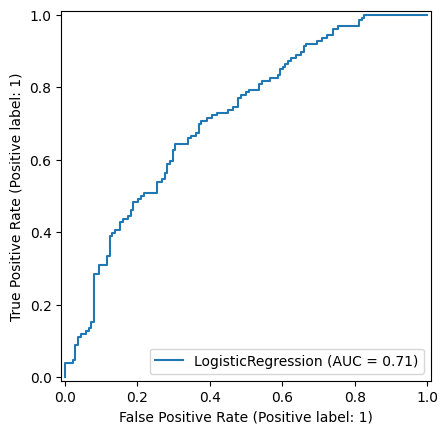

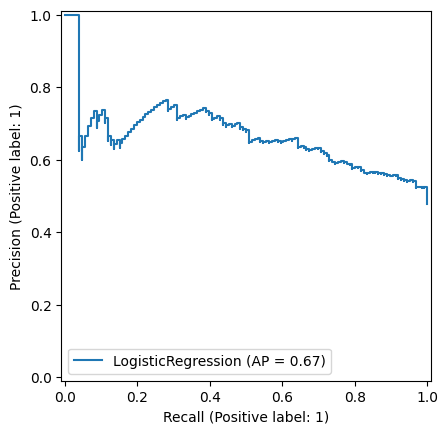

In [55]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)


PrecisionRecallDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)





In [56]:
from sklearn.metrics import roc_curve

y_probs = lr_clf.predict_proba(X_test[selected_features])[:, 1]

# Compute ROC curve metrics
fpr, tpr, thresholds = roc_curve( y_test.values.ravel(), y_probs)

# Create a DataFrame to store the metrics
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})


In [57]:
roc_df.to_csv(
    "roc/uti.tsv",
    sep="\t"
)

# Probability Prediction

In [58]:
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

design_matrix_test['sample'] = design_matrix_test['injection']
design_matrix_test['group'] = 1

quant_matrix_predict = QuantMatrix(
    quantification_file=ms_data_test,
    design_matrix_file=design_matrix_test,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
).impute(method="uniform_percentile", percentile=0.01)

predict_data, y_test_alll = quant_matrix_predict.to_ml(feature_column="ProteinLabel")

In [59]:
predict_data = predict_data[protein_columns].copy()

In [60]:
predict_data[protein_columns] = protein_scaler.transform(predict_data[protein_columns])

In [61]:
predict_data['uti_probability'] = lr_clf.predict_proba(predict_data[selected_features])[:, 1]

In [62]:
design_matrix_test = design_matrix_test.set_index("injection").join(
    predict_data['uti_probability']
).reset_index()

In [63]:
predict_data[['uti_probability']].to_csv(
    "predictions_test/uti.tsv",
    sep="\t"
)

<Axes: xlabel='uti_probability', ylabel='Count'>

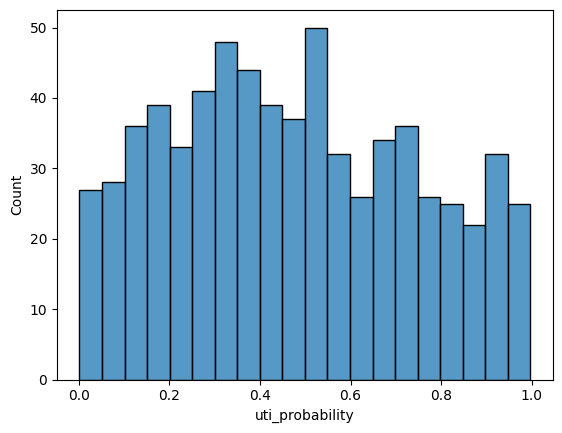

In [64]:
sns.histplot(
    data=design_matrix_test,
    x="uti_probability",
    #hue="sofa_uti_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [65]:
ms_data_val = pd.read_csv(
    "../0_data/proteins_val_filtered.tsv"
    , sep="\t"
)

design_matrix_val = pd.read_csv(
    "../0_data/design_matrix_validation.tsv",
    sep='\t'
)

design_matrix_val['sample'] = design_matrix_val['injection']
design_matrix_val['group'] = 1

quant_matrix_val = QuantMatrix(
    quantification_file=ms_data_val,
    design_matrix_file=design_matrix_val,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

val_data, y_val = quant_matrix_val.to_ml(feature_column="ProteinLabel")

In [66]:
val_data = val_data[protein_columns].copy()

In [67]:
val_data[protein_columns] = protein_scaler.transform(val_data[protein_columns])

In [68]:
val_data['uti_probability'] = lr_clf.predict_proba(val_data[selected_features])[:, 1]

In [69]:
design_matrix_val = design_matrix_val.set_index("injection").join(
    val_data['uti_probability']
).reset_index()

In [70]:
val_data[['uti_probability']].to_csv(
    "predictions_val/uti.tsv",
    sep="\t"
)

<Axes: xlabel='uti_probability', ylabel='Count'>

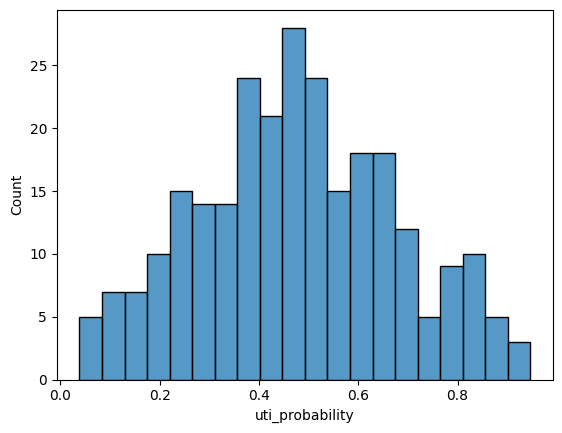

In [71]:
sns.histplot(
    data=design_matrix_val,
    x="uti_probability",
    #hue="sofa_uti_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [72]:
ms_data_hero = pd.read_csv(
    "../0_data/proteins_hero_filtered.tsv"
    , sep="\t"
)

design_matrix_hero = pd.read_csv(
    "../0_data/design_matrix_hero.tsv",
    sep='\t'
)

design_matrix_hero['sample'] = design_matrix_hero['injection']
design_matrix_hero['group'] = 1

quant_matrix_hero = QuantMatrix(
    quantification_file=ms_data_hero,
    design_matrix_file=design_matrix_hero,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

hero_data, y_hero = quant_matrix_hero.to_ml(feature_column="ProteinLabel")

In [73]:
hero_data = hero_data[protein_columns].copy()

In [74]:
hero_data[protein_columns] = protein_scaler.transform(hero_data[protein_columns])

In [75]:
hero_data['uti_probability'] = lr_clf.predict_proba(hero_data[selected_features])[:, 1]

In [76]:
design_matrix_hero = design_matrix_hero.set_index("injection").join(
    hero_data['uti_probability']
).reset_index()

In [77]:
hero_data[['uti_probability']].to_csv(
    "predictions_external/uti.tsv",
    sep="\t"
)

<Axes: xlabel='uti_probability', ylabel='Count'>

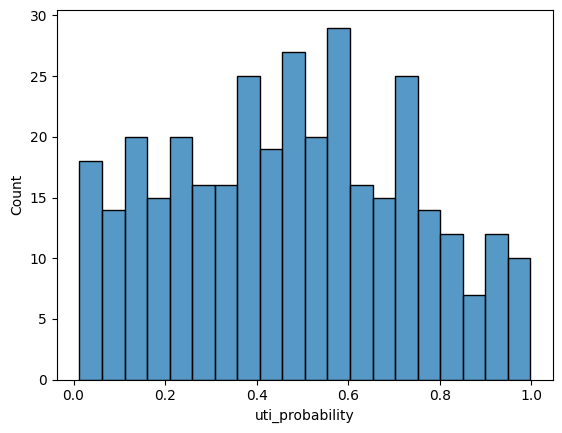

In [78]:
sns.histplot(
    data=hero_data,
    x="uti_probability",
    #hue="sofa_uti_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [79]:
from joblib import dump


with open("models/uti_protein_model.pkl", "wb") as f:

    dump(lr_clf, f)

with open("models/uti_protein_scaler.pkl", "wb") as f:

    dump(protein_scaler, f)
